In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


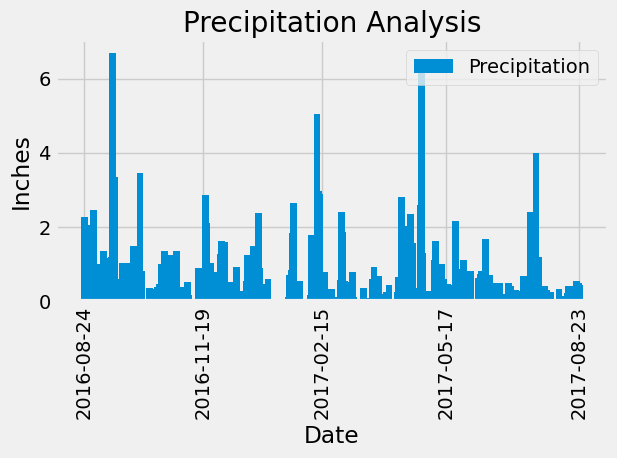

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date_str = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date_str, '%Y-%m-%d')

one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])


# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
# Get the range of dates to be displayed on the x-axis
date_range = precipitation_df['Date'].tolist()

# Choose four or five specific dates for reference
reference_dates = [date_range[i] for i in range(0, len(date_range), len(date_range) // 4)]  # Adjust this according to your preference

# Plot the precipitation data
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], width=5, label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation Analysis')
plt.xticks(reference_dates, rotation='vertical')  # Set reference dates as ticks and rotate them vertically
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()
print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(f"The total number of stations in the dataset is: {total_stations}")

The total number of stations in the dataset is: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order.
for station, count in active_stations:
    print(f"Station ID: {station}, Count: {count}")

Station ID: USC00519281, Count: 2772
Station ID: USC00519397, Count: 2724
Station ID: USC00513117, Count: 2709
Station ID: USC00519523, Count: 2669
Station ID: USC00516128, Count: 2612
Station ID: USC00514830, Count: 2202
Station ID: USC00511918, Count: 1979
Station ID: USC00517948, Count: 1372
Station ID: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0] if active_stations else None

if most_active_station:
    # Query to calculate lowest, highest, and average temperature for the most active station
    temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == most_active_station).all()

    # Extract the temperature statistics
    lowest_temp, highest_temp, avg_temp = temperature_stats[0]

    print(f"For the most active station (Station ID: {most_active_station}):")
    print(f"Lowest Temperature: {lowest_temp}°F")
    print(f"Highest Temperature: {highest_temp}°F")
    print(f"Average Temperature: {avg_temp}°F")
else:
    print("No active stations found.")

For the most active station (Station ID: USC00519281):
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66378066378067°F


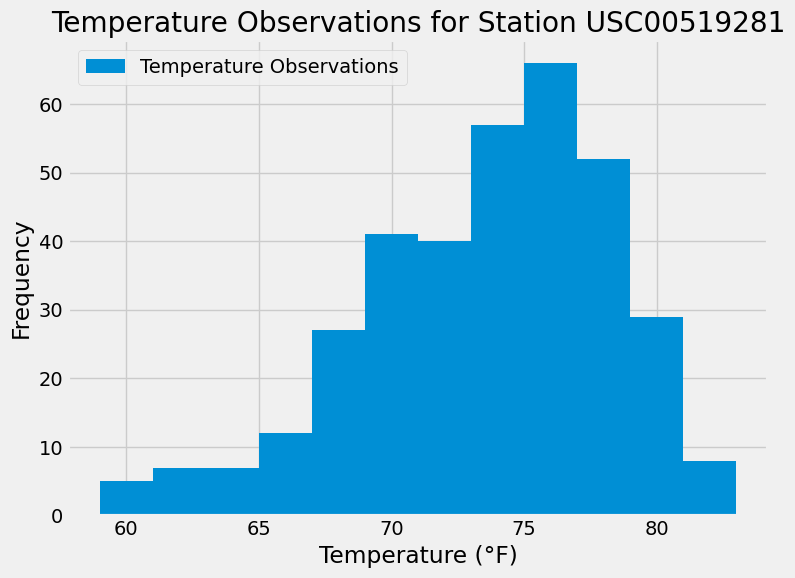

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Query to retrieve the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df['Temperature'], bins=12, label='Temperature Observations')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station}')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()